In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from deside.utility import set_fig_style, do_pca_analysis
from deside.utility.read_file import ReadH5AD, ReadExp

set_fig_style(font_family='Arial', font_size=8)

In [3]:
dataset_dir = r'../datasets/simulated_bulk_cell_dataset/'
fig_dir = './fig1/'
d1_file_path = os.path.join(dataset_dir, 'segment_7ds_0.95_n_base100_median_gep', 'simu_bulk_exp_Mixed_N100K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.h5ad')
d2_file_path = os.path.join(dataset_dir, 'segment_7ds_0.95_n_base100_median_gep', 'simu_bulk_exp_Mixed_N100K_segment_without_filtering_log2cpm1p.h5ad')
d0_file_path = os.path.join(dataset_dir, 'random_7ds_n_base100', 'simu_bulk_exp_Mixed_N100K_random_log2cpm1p.h5ad')
tcga_file_path = os.path.join('../datasets/TCGA/tpm/merged_tpm.csv')

In [4]:
tcga_tpm = ReadExp(tcga_file_path, exp_type='TPM').get_exp()

In [5]:
tcga_tpm.head(2)

,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-OR-A5LO-01A,0.00,0.017,38.699,0.348,47.470,4.111,6.210,10.764,11.583,0.357,...,0.007,46.981,3.398,0.488,76.426,194.197,17.441,23.289,9.881,10.631
TCGA-P6-A5OG-01A,0.04,0.320,34.088,1.190,113.829,4.699,4.788,28.043,6.925,0.025,...,0.000,97.026,5.841,0.518,11.899,47.232,34.115,60.080,22.208,19.748


In [6]:
def get_pc_simu_bulk_with_tcga(simu_ds_name, ds_file_path, tcga_exp, pca_model_file_path):
    inx2class = {}
    simu_bulk_exp_obj = ReadH5AD(ds_file_path)
    simu_bulk_exp = simu_bulk_exp_obj.get_df()
    common_genes = [i for i in simu_bulk_exp.columns.to_list() if i in tcga_exp.columns]
    
    bulk_obj = ReadExp(simu_bulk_exp, exp_type='log_space')
    bulk_obj.align_with_gene_list(gene_list=common_genes)
    bulk_exp = bulk_obj.get_exp()

    tcga_obj = ReadExp(tcga_exp, exp_type='TPM')
    tcga_obj.align_with_gene_list(gene_list=common_genes)
    tcga_obj.to_log2cpm1p()
    tcga_exp_new = tcga_obj.get_exp()
    
    simu_bulk_with_tcga = pd.concat([bulk_exp, tcga_exp_new])
    # print(simu_bulk_with_tcga.shape)
    # print(simu_bulk_with_tcga.head(2))
    pca_model = do_pca_analysis(exp_df=simu_bulk_with_tcga, n_components=2,
                                pca_result_fp=pca_model_file_path)
    pcs = pca_model.transform(simu_bulk_with_tcga)
    pca_df = pd.DataFrame(pcs[:, range(2)], index=simu_bulk_with_tcga.index, columns=['PC1', 'PC2'])
    for inx in pca_df.index.to_list():
        if inx in bulk_exp.index:
            inx2class[inx] = simu_ds_name
        else:
            inx2class[inx] = 'TCGA'
    pca_df['class'] = pca_df.index.map(lambda x: inx2class[x])
    return pca_df

In [7]:
dataset2color = {'TCGA': 'C5', 'D0': 'C0', 'D1': 'C1', 'D2': 'C2'}

## PCA plot of simulated datasets and TCGA

### D1 and TCGA

In [8]:
simu_ds_name = 'D1'
pca_model_file_path = os.path.join(dataset_dir, f'TCGA_{simu_ds_name}_PCA.joblib')
d1_tcga_pca = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d1_file_path, tcga_exp=tcga_tpm, pca_model_file_path=pca_model_file_path)
print(d1_tcga_pca.shape)
d1_tcga_pca.head(2)

6168 common genes will be used, 0 genes will be removed.
6168 common genes will be used, 13544 genes will be removed.
(107699, 3)


,PC1,PC2,class
s_segment_0_1033,1.122879,17.696901,D1
s_segment_0_104,26.180947,-26.918494,D1


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


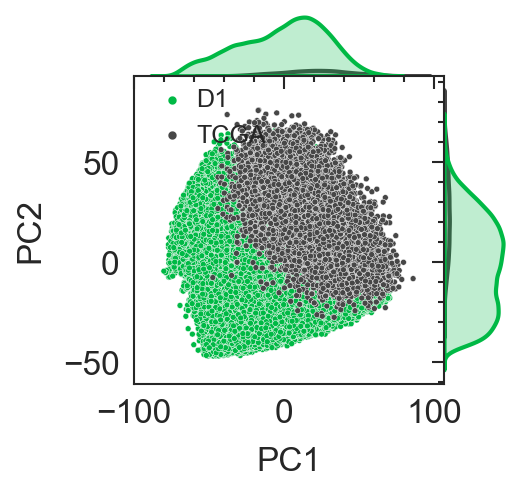

In [9]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d1_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color)
g1_ax = g1.ax_joint
g1_ax.set_xticks([-100, 0.0, 100])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)

plt.savefig(os.path.join(fig_dir, f'TCGA_{simu_ds_name}_PCA.svg'), dpi=300)

### D2 and TCGA

In [10]:
simu_ds_name = 'D2'
pca_model_file_path = os.path.join(dataset_dir, f'TCGA_{simu_ds_name}_PCA.joblib')
d2_tcga_pca = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d2_file_path, tcga_exp=tcga_tpm, pca_model_file_path=pca_model_file_path)
print(d2_tcga_pca.shape)
d2_tcga_pca.head(2)

12114 common genes will be used, 0 genes will be removed.
12114 common genes will be used, 7598 genes will be removed.
(107699, 3)


,PC1,PC2,class
s_segment_0_1,41.859921,-15.910505,D2
s_segment_0_10,-1.249738,-24.590528,D2


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


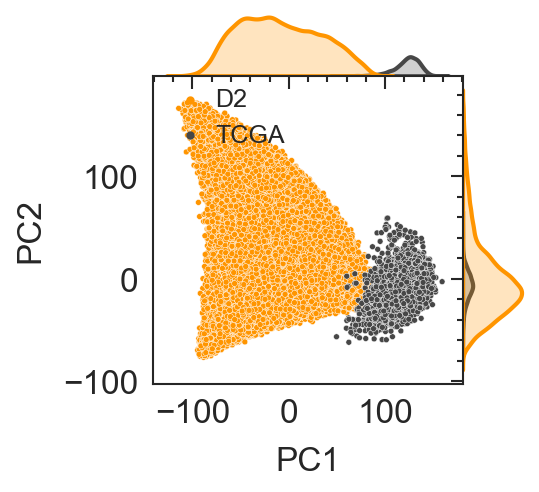

In [11]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d2_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color)
g1_ax = g1.ax_joint
# g1_ax.set_xticks([-5, 0.0, 5.0])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)

plt.savefig(os.path.join(fig_dir, f'TCGA_{simu_ds_name}_PCA.svg'), dpi=300)

### D0 and TCGA

In [12]:
simu_ds_name = 'D0'
pca_model_file_path = os.path.join(dataset_dir, f'TCGA_{simu_ds_name}_PCA.joblib')
d0_tcga_pca = get_pc_simu_bulk_with_tcga(simu_ds_name=simu_ds_name, ds_file_path=d0_file_path, tcga_exp=tcga_tpm, pca_model_file_path=pca_model_file_path)
print(d0_tcga_pca.shape)
d0_tcga_pca.head(2)

12114 common genes will be used, 0 genes will be removed.
12114 common genes will be used, 7598 genes will be removed.
(107699, 3)


,PC1,PC2,class
s_random_0_0,-8.002162,4.061836,D0
s_random_0_1,-5.542467,17.494855,D0


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


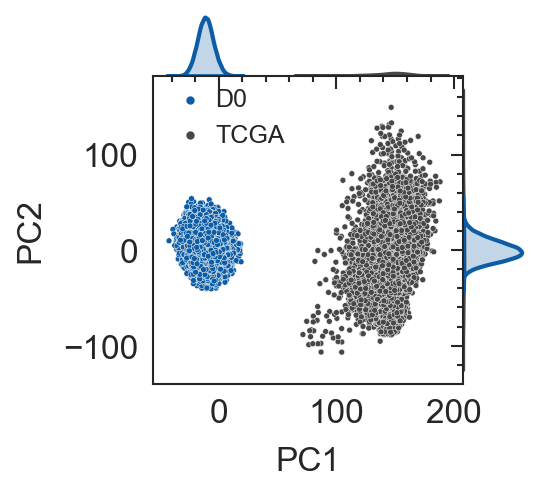

In [13]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=d0_tcga_pca, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color)
g1_ax = g1.ax_joint
# g1_ax.set_xticks([-5, 0.0, 5.0])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)

plt.savefig(os.path.join(fig_dir, f'TCGA_{simu_ds_name}_PCA.svg'), dpi=300)